In [ ]:
# Distance matrix
distance_matrix = [
    [0, 12, 10, 24, 13, 21, 12],  
    [12, 0, 8, 12, 11, 17, 17],   
    [10, 8, 0, 11, 3, 9, 9],      
    [24, 12, 11, 0, 11, 10, 18],  
    [13, 11, 3, 11, 0, 6, 7],     
    [21, 17, 9, 10, 6, 0, 9],     
    [12, 17, 9, 18, 7, 9, 0]      
]

### Branch and Bound Method

In [17]:
import numpy as np

class TSPSolver:
    def __init__(self, distance_matrix):
        self.n = len(distance_matrix)
        self.dist = distance_matrix
        self.final_res = float('inf')
        self.final_path = [None] * (self.n + 1)
        self.visited = [False] * self.n
    
    def copy_to_final(self, curr_path):
        self.final_path[:self.n + 1] = curr_path[:]
        self.final_path[self.n] = curr_path[0]
    
    def first_min(self, i):
        min_val = float('inf')
        for k in range(self.n):
            if self.dist[i][k] < min_val and i != k:
                min_val = self.dist[i][k]
        return min_val
    
    def second_min(self, i):
        first, second = float('inf'), float('inf')
        for j in range(self.n):
            if i == j:
                continue
            if self.dist[i][j] <= first:
                second = first
                first = self.dist[i][j]
            elif self.dist[i][j] <= second and self.dist[i][j] != first:
                second = self.dist[i][j]
        return second
    
    def tsp_rec(self, curr_bound, curr_weight, level, curr_path):
        if level == self.n:
            if self.dist[curr_path[level - 1]][curr_path[0]] != 0:
                curr_res = curr_weight + self.dist[curr_path[level - 1]][curr_path[0]]
                if curr_res < self.final_res:
                    self.copy_to_final(curr_path)
                    self.final_res = curr_res
            return
        
        for i in range(self.n):
            if self.dist[curr_path[level - 1]][i] != 0 and not self.visited[i]:
                temp = curr_bound
                curr_weight += self.dist[curr_path[level - 1]][i]
                if level == 1:
                    curr_bound -= ((self.first_min(curr_path[level - 1]) + self.first_min(i)) / 2)
                else:
                    curr_bound -= ((self.second_min(curr_path[level - 1]) + self.first_min(i)) / 2)
                
                if curr_bound + curr_weight < self.final_res:
                    curr_path[level] = i
                    self.visited[i] = True
                    self.tsp_rec(curr_bound, curr_weight, level + 1, curr_path)
                
                curr_weight -= self.dist[curr_path[level - 1]][i]
                curr_bound = temp
                self.visited = [False] * len(self.visited)
                for j in range(level):
                    if curr_path[j] != -1:
                        self.visited[curr_path[j]] = True
    
    def tsp(self):
        curr_bound = 0
        curr_path = [-1] * (self.n + 1)
        for i in range(self.n):
            curr_bound += (self.first_min(i) + self.second_min(i))
        
        curr_bound = (curr_bound // 2)
        
        self.visited[0] = True
        curr_path[0] = 0
        self.tsp_rec(curr_bound, 0, 1, curr_path)
        # Convert the final path to start from 1 instead of 0
        final_path_converted = [city + 1 for city in self.final_path]
        return self.final_res, final_path_converted

solver = TSPSolver(distance_matrix)
final_res, final_path = solver.tsp()
print(f"Minimum distance: {final_res}")
print(f"Path taken: {final_path}")

Minimum distance: 63
Path taken: [1, 3, 5, 7, 6, 4, 2, 1]


### Brute-Force Method

In [15]:
from itertools import permutations

# Function to calculate the total distance of a given path
def calculate_distance(path):
    total_distance = 0
    for i in range(len(path) - 1):
        total_distance += distance_matrix[path[i]][path[i + 1]]
    total_distance += distance_matrix[path[-1]][path[0]]  
    return total_distance

def find_optimal_path():
    min_distance = float('inf')
    best_path = None
    for perm in permutations(cities[1:]):  
        current_path = [0] + list(perm)
        current_distance = calculate_distance(current_path)
        if current_distance < min_distance:
            min_distance = current_distance
            best_path = current_path
    return best_path, min_distance

optimal_path, optimal_distance = find_optimal_path()

# Converting city indices to start with 1 and adding city 1 at the end
optimal_path_1_based = [city + 1 for city in optimal_path] + [optimal_path[0] + 1]

print(f"Optimal Path: {optimal_path_1_based}")
print(f"Minimum Distance: {optimal_distance}")

Optimal Path: [1, 2, 4, 6, 7, 5, 3, 1]
Minimum Distance: 63


### Dynamic Programming (Held-Karp)

In [10]:
from itertools import combinations

def held_karp(matrix):
    n = len(matrix)
    C = {}

    # Initializing the distance to start from city 1 (index 0 in the matrix)
    for k in range(1, n):
        C[(1 << k, k)] = (matrix[0][k], 0)

    # Iterating over subsets of increasing size
    for subset_size in range(2, n):
        for subset in combinations(range(1, n), subset_size):
            bits = 0
            for bit in subset:
                bits |= 1 << bit

            for k in subset:
                prev_bits = bits & ~(1 << k)
                res = []
                for m in subset:
                    if m == 0 or m == k:
                        continue
                    res.append((C[(prev_bits, m)][0] + matrix[m][k], m))
                C[(bits, k)] = min(res)

    # Calculating the optimal path
    bits = (2**n - 1) - 1
    res = []
    for k in range(1, n):
        res.append((C[(bits, k)][0] + matrix[k][0], k))
    opt, parent = min(res)

    # Reconstructing the optimal path
    path = []
    for i in range(n - 1):
        path.append(parent)
        bits, parent = bits & ~(1 << parent), C[(bits, parent)][1]
    path.append(0)
    path = list(reversed(path))
    path.append(0)  

    return opt, path

optimal_distance, optimal_path = held_karp(distance_matrix)
print("Optimal Path:", [city + 1 for city in optimal_path])  
print("Optimal Distance:", optimal_distance)

Optimal Path: [1, 3, 5, 7, 6, 4, 2, 1]
Optimal Distance: 63


### Nearest Neighbor Method

In [7]:
def calculate_distance_nearest(path, matrix):
    distance = 0
    for i in range(len(path) - 1):
        distance += matrix[path[i]][path[i+1]]
    return distance

In [9]:
def nearest_neighbor(matrix, start=0):
    n = len(matrix)
    visited = [False] * n
    path = [start]
    visited[start] = True
    current = start

    while len(path) < n:
        next_city = min((matrix[current][j], j) for j in range(n) if not visited[j])[1]
        path.append(next_city)
        visited[next_city] = True
        current = next_city
# Returning to city one
    path.append(start)  
    return path, calculate_distance_nearest(path, matrix)

optimal_path, optimal_distance = nearest_neighbor(distance_matrix, start=0)
print("Optimal Path:", [city + 1 for city in optimal_path])
print("Optimal Distance:", optimal_distance)

Optimal Path: [1, 3, 5, 6, 7, 2, 4, 1]
Optimal Distance: 81


### Self-Organizing Map

Sub-Optimal Path: [1, 2, 3, 4, 5, 6, 7, 1]
Total Distance of Sub-Optimal Path: 69


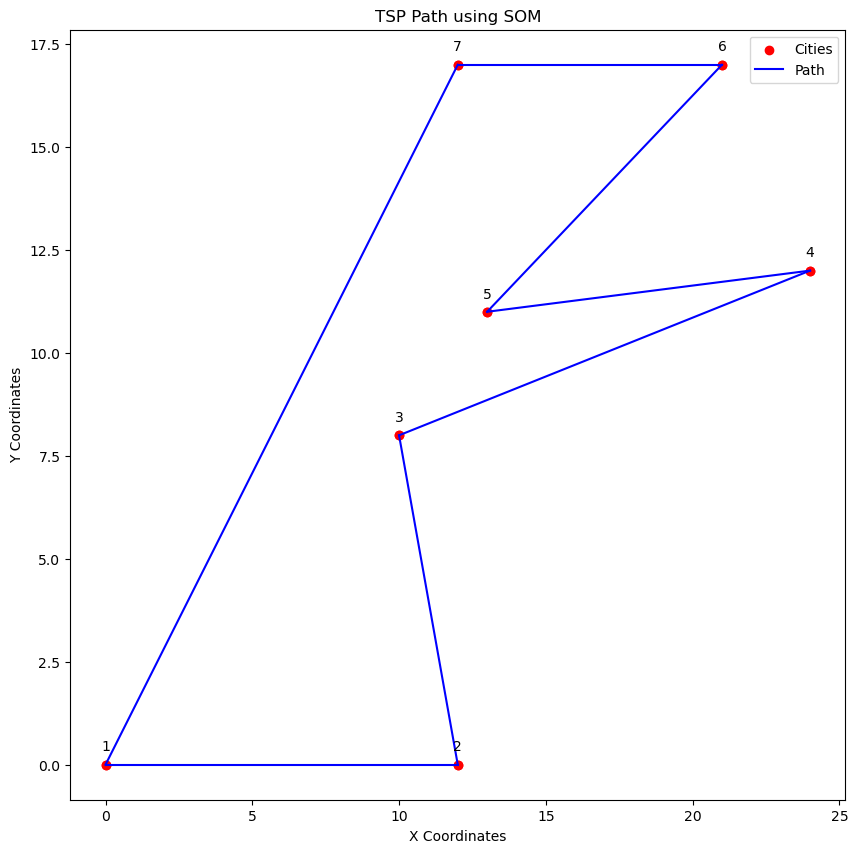

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Distance matrix
distance_matrix = np.array([
    [0, 12, 10, 24, 13, 21, 12],
    [12, 0, 8, 12, 11, 17, 17],
    [10, 8, 0, 11, 3, 9, 9],
    [24, 12, 11, 0, 11, 10, 18],
    [13, 11, 3, 11, 0, 6, 7],
    [21, 17, 9, 10, 6, 0, 9],
    [12, 17, 9, 18, 7, 9, 0]
])

# City coordinates (for visualization purposes)
city_coordinates = np.array([
    [0, 0],
    [12, 0],
    [10, 8],
    [24, 12],
    [13, 11],
    [21, 17],
    [12, 17]
])

city_labels = ['1', '2', '3', '4', '5', '6', '7']

class SOM:
    def __init__(self, num_nodes, num_cities, learning_rate=0.8, radius=2):
        self.num_nodes = num_nodes
        self.num_cities = num_cities
        self.learning_rate = learning_rate
        self.radius = radius
        self.nodes = np.random.rand(num_nodes, 2)
    
    def train(self, city_coordinates, num_iterations=1000):
        for iteration in range(num_iterations):
            city_index = np.random.randint(0, self.num_cities)
            city = city_coordinates[city_index]
            
            bmu_index = self.find_bmu(city)
            
            self.update_nodes(city, bmu_index, iteration, num_iterations)
    
    def find_bmu(self, city):
        distances = np.linalg.norm(self.nodes - city, axis=1)
        return np.argmin(distances)
    
    def update_nodes(self, city, bmu_index, iteration, num_iterations):
        learning_rate = self.learning_rate * np.exp(-iteration / num_iterations)
        radius = self.radius * np.exp(-iteration / num_iterations)
        
        for i in range(self.num_nodes):
            distance_to_bmu = np.linalg.norm(i - bmu_index)
            if distance_to_bmu < radius:
                influence = np.exp(-distance_to_bmu / (2 * (radius ** 2)))
                self.nodes[i] += influence * learning_rate * (city - self.nodes[i])
    
    def get_path_indices(self, city_coordinates):
        path_indices = []
        for city in city_coordinates:
            bmu_index = self.find_bmu(city)
            path_indices.append(np.argmin(np.linalg.norm(city_coordinates - self.nodes[bmu_index], axis=1)))
        return path_indices

def calculate_path_distance(path_indices, distance_matrix):
    distance = 0
    for i in range(len(path_indices) - 1):
        distance += distance_matrix[path_indices[i], path_indices[i + 1]]
    distance += distance_matrix[path_indices[-1], path_indices[0]] 
    return distance

som = SOM(num_nodes=20, num_cities=len(city_coordinates))
som.train(city_coordinates)

path_indices = som.get_path_indices(city_coordinates)
path_indices.append(path_indices[0])  
path_distance = calculate_path_distance(path_indices, distance_matrix)

path_indices_1_based = [i + 1 for i in path_indices]

# Printing the sub-optimal path and its distance
print("Sub-Optimal Path:", path_indices_1_based)
print("Total Distance of Sub-Optimal Path:", path_distance)

# Visualizing the results
plt.figure(figsize=(10, 10))
plt.scatter(city_coordinates[:, 0], city_coordinates[:, 1], c='red', label='Cities')
plt.plot(city_coordinates[:, 0], city_coordinates[:, 1], 'ro')

# Adding city labels
for i, txt in enumerate(city_labels):
    plt.annotate(txt, (city_coordinates[i, 0], city_coordinates[i, 1]), textcoords="offset points", xytext=(0,10), ha='center')

for i in range(len(path_indices) - 1):
    start_city = city_coordinates[path_indices[i]]
    end_city = city_coordinates[path_indices[i + 1]]
    plt.plot([start_city[0], end_city[0]], [start_city[1], end_city[1]], 'b-')

plt.plot([city_coordinates[path_indices[-1]][0], city_coordinates[path_indices[0]][0]], 
         [city_coordinates[path_indices[-1]][1], city_coordinates[path_indices[0]][1]], 'b-', label='Path')

plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.title('TSP Path using SOM')
plt.legend()
plt.show()